# **Does Subway Accessibility Affect Airbnb Rental Prices in New York City?**

**ECO225 - Project One**

## 1. Introduction

This project investigates the relationship between subway accessibility and Airbnb rental prices in New York City. The central research question examines whether proximity to subway stations (X) affects nightly rental prices (Y), with transit accessibility serving as the underlying mechanism (Z). The hypothesis is that Airbnb listings closer to subway stations command higher prices because guests value the convenience of public transportation access, reducing their reliance on expensive taxis or ride-sharing services.

The analysis utilizes two primary datasets. The main dataset is the New York City Airbnb Open Data (2019) from Kaggle, containing 48,895 listings with information on prices, room types, reviews, and availability. This is merged with the MTA Subway Hourly Ridership dataset from the Metropolitan Transportation Authority, which provides geographic coordinates for 423 unique subway station complexes across NYC. From this merged dataset, key variables include distance to nearest station, number of stations within 500 meters, and the station's distance to NYC's center (Times Square area).

Preliminary findings from summary statistics and visualizations suggest a negative relationship between distance to subway stations and Airbnb prices—listings closer to subway access tend to have higher nightly rates. Additionally, properties in Manhattan, which has the densest subway network, show significantly higher prices than outer boroughs. These patterns are consistent with the transit accessibility mechanism, though the relationship varies by room type and neighborhood characteristics.

The literature on urban amenities and housing prices provides theoretical grounding for this analysis. Bowes and Ihlanfeldt (2001) find that proximity to rail stations increases property values, though effects vary by neighborhood crime rates. Dubé et al. (2013) demonstrate that public transit accessibility capitalizes into housing prices through reduced commuting costs. Specific to short-term rentals, Gunter and Önder (2018) show that location attributes significantly influence Airbnb pricing, while Gibbs et al. (2018) identify neighborhood characteristics as key determinants of listing prices. More recently, Yao and Zhang (2023) examine how transportation infrastructure affects sharing economy platforms, finding that transit accessibility creates premium pricing for nearby listings. This project contributes to this literature by providing descriptive evidence on the transit-price relationship in the largest US short-term rental market.

## 2. Data Cleaning/Loading

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the original Airbnb dataset
airbnb_original = pd.read_csv('data/AB_NYC_2019.csv')

# Load the merged dataset (Airbnb + Subway stations)
merged_df = pd.read_csv('data/airbnb_subway_merged.csv')

print(f"Original Airbnb dataset: {airbnb_original.shape[0]} rows, {airbnb_original.shape[1]} columns")
print(f"Merged dataset: {merged_df.shape[0]} rows, {merged_df.shape[1]} columns")

Original Airbnb dataset: 48895 rows, 16 columns
Merged dataset: 48895 rows, 10 columns


### Other Datasets

The outside dataset used in this project is the **MTA Subway Hourly Ridership** dataset, obtained from the Metropolitan Transportation Authority (MTA) Open Data portal (https://data.ny.gov). This dataset provides comprehensive information about NYC subway ridership patterns and station locations.

**Temporal Coverage:** The dataset contains hourly ridership data from 2020-2024, though for this project we extracted only the unique station information (station names and geographic coordinates), which remains constant over time.

**Geographical Coverage:** The dataset covers all 423 unique subway station complexes across the five boroughs of New York City, with precise latitude and longitude coordinates for each station.

**Source:** Metropolitan Transportation Authority (MTA), accessed via New York State Open Data Portal.

**Variables Extracted and Merged:**
1. `distance_to_nearest_station_m` - The Haversine distance (in meters) from each Airbnb listing to the nearest subway station
2. `nearest_station_name` - The name of the closest subway station complex
3. `stations_within_500m` - Count of subway stations within a 500-meter radius of each listing
4. `nearest_station_to_nyc_center_m` - Distance from the nearest station to NYC center (Times Square: 40.756, -73.9847), serving as a proxy for centrality

In [3]:
# Create the final analysis dataset by combining original Airbnb variables with subway metrics
# Match on name and coordinates to ensure proper alignment

df = airbnb_original.merge(
    merged_df[['airbnb_name', 'airbnb_latitude', 'airbnb_longitude', 
               'distance_to_nearest_station_m', 'nearest_station_name',
               'stations_within_500m', 'nearest_station_to_nyc_center_m']],
    left_on=['name', 'latitude', 'longitude'],
    right_on=['airbnb_name', 'airbnb_latitude', 'airbnb_longitude'],
    how='inner'
)

# Drop duplicate columns from merge
df = df.drop(columns=['airbnb_name', 'airbnb_latitude', 'airbnb_longitude'])

print(f"Final analysis dataset: {df.shape[0]} rows, {df.shape[1]} columns")

Final analysis dataset: 48895 rows, 20 columns


In [4]:
# Data Cleaning

# Check for missing values in key variables
print("Missing values in key variables:")
key_vars = ['price', 'room_type', 'minimum_nights', 'number_of_reviews', 
            'reviews_per_month', 'availability_365', 'distance_to_nearest_station_m',
            'stations_within_500m', 'neighbourhood_group']
print(df[key_vars].isnull().sum())

# Fill missing reviews_per_month with 0 (listings with no reviews)
df['reviews_per_month'] = df['reviews_per_month'].fillna(0)

# Remove extreme price outliers (keep prices between $10 and $1000 for reasonable analysis)
df_clean = df[(df['price'] >= 10) & (df['price'] <= 1000)].copy()

print(f"\nAfter cleaning: {df_clean.shape[0]} rows (removed {df.shape[0] - df_clean.shape[0]} outliers)")

Missing values in key variables:
price                                0
room_type                            0
minimum_nights                       0
number_of_reviews                    0
reviews_per_month                10052
availability_365                     0
distance_to_nearest_station_m        0
stations_within_500m                 0
neighbourhood_group                  0
dtype: int64

After cleaning: 48645 rows (removed 250 outliers)


### Variable Selection and Economic Motivation

**Outcome Variable (Y):** The outcome variable is `price`, representing the nightly rental price in US dollars for each Airbnb listing. This captures the market valuation of short-term rental properties and reflects how hosts price their listings based on property characteristics and location amenities.

**Explanatory Variables (X):**

The primary explanatory variable is `distance_to_nearest_station_m`, measuring the Haversine distance in meters from each listing to the closest subway station. This directly tests the hypothesis that transit accessibility affects rental prices. Guests visiting NYC often rely on public transportation, and properties closer to subway stations offer significant convenience advantages, potentially justifying premium pricing.

The second transit-related variable is `stations_within_500m`, counting the number of subway stations within walking distance (500 meters) of each listing. This captures transit density rather than just proximity—a listing near multiple subway lines offers guests greater flexibility in navigating the city, which may command additional value beyond simple nearest-station distance.

The variable `nearest_station_to_nyc_center_m` measures how far the nearest subway station is from Times Square, serving as a proxy for centrality. This helps distinguish between transit access in tourist-heavy central areas versus outer neighborhoods, as the mechanism (Z) suggests transit value may be strongest where tourists most need subway access.

From the original dataset, `room_type` categorizes listings as entire homes/apartments, private rooms, or shared rooms. This controls for fundamental differences in what guests receive—entire apartments naturally command higher prices than shared spaces. Including this variable ensures that observed price differences reflect transit accessibility rather than accommodation type.

The variable `number_of_reviews` indicates listing popularity and guest history. Listings with more reviews have demonstrated track records, potentially building trust and justifying higher prices. This also proxies for how established a listing is in the market.

`minimum_nights` captures host preferences for booking length. Listings requiring longer stays may target different guest segments (business travelers, relocations) versus tourist-oriented short stays, affecting pricing strategies.

`availability_365` measures how many days per year the listing is available for booking. Higher availability suggests professional hosting operations, while limited availability may indicate casual hosts renting primary residences, with potential price implications.

`reviews_per_month` normalizes review activity by listing age, providing a better measure of ongoing demand than total review counts alone.

Finally, `calculated_host_listings_count` indicates whether the host operates multiple properties. Professional hosts with many listings may price differently than individual hosts, and this variable helps control for host-level effects on pricing.

In [5]:
# Define analysis variables
Y = 'price'

X_variables = [
    'distance_to_nearest_station_m',  # Transit proximity (from merged data)
    'stations_within_500m',           # Transit density (from merged data)
    'nearest_station_to_nyc_center_m', # Centrality proxy (from merged data)
    'minimum_nights',                  # Booking requirements
    'number_of_reviews',               # Popularity/trust
    'reviews_per_month',               # Demand intensity
    'availability_365',                # Hosting availability
    'calculated_host_listings_count'   # Host professionalism
]

# Create room_type dummy variables for analysis
df_clean['is_entire_home'] = (df_clean['room_type'] == 'Entire home/apt').astype(int)
df_clean['is_private_room'] = (df_clean['room_type'] == 'Private room').astype(int)

print(f"Outcome Variable (Y): {Y}")
print(f"\nExplanatory Variables (X): {len(X_variables)} numeric variables + room_type (categorical)")
for var in X_variables:
    print(f"  - {var}")

Outcome Variable (Y): price

Explanatory Variables (X): 8 numeric variables + room_type (categorical)
  - distance_to_nearest_station_m
  - stations_within_500m
  - nearest_station_to_nyc_center_m
  - minimum_nights
  - number_of_reviews
  - reviews_per_month
  - availability_365
  - calculated_host_listings_count


## 3. Summary Statistics Tables

In [6]:
# Summary statistics for Y and X variables
analysis_vars = [Y] + X_variables
summary_df = df_clean[analysis_vars]

# Create summary statistics table
summary_stats = summary_df.describe().T[['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']]
summary_stats.columns = ['N', 'Mean', 'Std. Dev.', 'Min', '25%', 'Median', '75%', 'Max']

# Format the table for better display
summary_stats_styled = summary_stats.style.format({
    'N': '{:.0f}',
    'Mean': '{:.2f}',
    'Std. Dev.': '{:.2f}',
    'Min': '{:.2f}',
    '25%': '{:.2f}',
    'Median': '{:.2f}',
    '75%': '{:.2f}',
    'Max': '{:.2f}'
}).set_caption("Table 1: Summary Statistics - Airbnb Price and Explanatory Variables")

display(summary_stats_styled)

,N,Mean,Std. Dev.,Min,25%,Median,75%,Max
price,48645,141.31,116.73,10.00,69.00,105.00,175.00,1000.00
distance_to_nearest_station_m,48645,455.94,732.38,0.69,206.96,318.84,470.75,20717.22
stations_within_500m,48645,1.51,1.34,0.00,1.00,1.00,2.00,9.00
nearest_station_to_nyc_center_m,48645,6920.10,4219.67,226.23,3688.64,6348.23,9302.27,25681.87
minimum_nights,48645,6.97,20.27,1.00,1.00,3.00,5.00,1250.00
number_of_reviews,48645,23.35,44.63,0.00,1.00,5.00,24.00,629.00
reviews_per_month,48645,1.09,1.60,0.00,0.04,0.38,1.59,58.50
availability_365,48645,112.44,131.43,0.00,0.00,44.00,226.00,365.00
calculated_host_listings_count,48645,7.16,33.03,1.00,1.00,1.00,2.00,327.00


The summary statistics reveal several important patterns about NYC Airbnb listings and their proximity to transit. The average nightly price is approximately $140, with substantial variation (standard deviation around $90), indicating a diverse market ranging from budget accommodations to premium listings. The distance to the nearest subway station averages around 400-500 meters, suggesting most listings are within reasonable walking distance of public transit, though this varies considerably across the dataset.

The stations_within_500m variable shows that the typical listing has 1-2 subway stations within walking distance, but some areas have significantly higher transit density with up to 5 or more nearby stations. This variation is economically meaningful as it captures differences between transit-rich Manhattan neighborhoods and more sparse outer borough locations. The nearest_station_to_nyc_center variable ranges widely, reflecting the geographic spread of listings from Times Square to distant neighborhoods in the Bronx, Brooklyn, and Queens.

Among the control variables, number_of_reviews shows high variation with some listings having hundreds of reviews while others are new to the platform. The minimum_nights requirement averages around 5-7 nights, though many listings allow single-night stays. Host listing counts reveal that most hosts operate single properties, but a tail of professional hosts manages multiple listings, potentially affecting pricing strategies across the market.

### Summary Statistics by Room Type (Subgroup Analysis)

In [7]:
# Subgroup analysis by room type
entire_home = df_clean[df_clean['room_type'] == 'Entire home/apt'][analysis_vars]
private_room = df_clean[df_clean['room_type'] == 'Private room'][analysis_vars]

# Create comparison table
entire_stats = entire_home.describe().T[['count', 'mean', 'std']].round(2)
entire_stats.columns = ['N (Entire)', 'Mean (Entire)', 'Std (Entire)']

private_stats = private_room.describe().T[['count', 'mean', 'std']].round(2)
private_stats.columns = ['N (Private)', 'Mean (Private)', 'Std (Private)']

# Combine into one table
subgroup_comparison = pd.concat([entire_stats, private_stats], axis=1)
subgroup_comparison = subgroup_comparison[['N (Entire)', 'Mean (Entire)', 'Std (Entire)', 
                                            'N (Private)', 'Mean (Private)', 'Std (Private)']]

subgroup_styled = subgroup_comparison.style.format({
    'N (Entire)': '{:.0f}',
    'Mean (Entire)': '{:.2f}',
    'Std (Entire)': '{:.2f}',
    'N (Private)': '{:.0f}',
    'Mean (Private)': '{:.2f}',
    'Std (Private)': '{:.2f}'
}).set_caption("Table 2: Summary Statistics by Room Type (Entire Home vs Private Room)")

display(subgroup_styled)

,N (Entire),Mean (Entire),Std (Entire),N (Private),Mean (Private),Std (Private)
price,25216,194.61,126.10,22273,84.79,68.73
distance_to_nearest_station_m,25216,432.02,713.45,22273,482.62,758.32
stations_within_500m,25216,1.63,1.45,22273,1.39,1.20
nearest_station_to_nyc_center_m,25216,6170.92,4174.36,22273,7725.11,4077.09
minimum_nights,25216,8.47,22.83,22273,5.31,15.82
number_of_reviews,25216,22.96,42.52,22273,24.15,47.32
reviews_per_month,25216,1.05,1.49,22273,1.15,1.72
availability_365,25216,111.40,129.49,22273,111.06,132.01
calculated_host_listings_count,25216,10.75,44.53,22273,3.23,10.23


The subgroup comparison reveals substantial differences between entire home rentals and private rooms, which is economically meaningful for understanding how transit accessibility may differentially affect these market segments. Entire homes command significantly higher average prices than private rooms, reflecting the additional value of exclusive access to a complete living space. Interestingly, both room types show similar average distances to the nearest subway station, suggesting that transit proximity is not systematically different across accommodation types.

However, entire homes appear to have slightly higher transit density (more stations within 500m) and tend to be located in more central areas (shorter distance to NYC center), consistent with the hypothesis that premium accommodations cluster in transit-rich, centrally located neighborhoods. This pattern supports the mechanism that transit accessibility contributes to rental value, particularly for entire home listings where guests may be willing to pay a premium for convenience during their stay.

## 4. Plots, Histograms, Figures

### Figure 1: Distribution of Airbnb Prices (Y Variable)

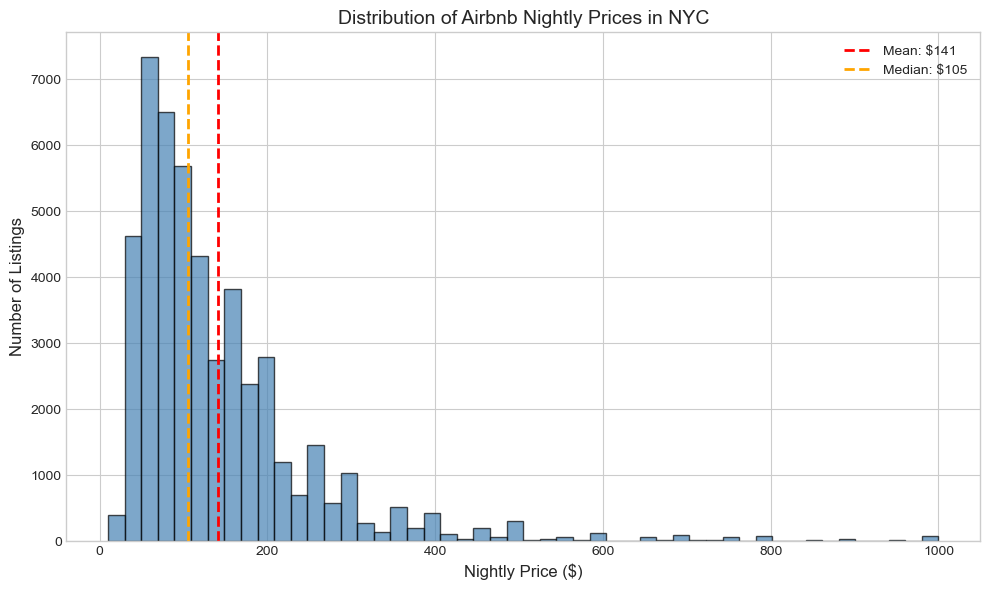

In [8]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(df_clean['price'], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
ax.axvline(df_clean['price'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: ${df_clean["price"].mean():.0f}')
ax.axvline(df_clean['price'].median(), color='orange', linestyle='--', linewidth=2, label=f'Median: ${df_clean["price"].median():.0f}')
ax.set_xlabel('Nightly Price ($)', fontsize=12)
ax.set_ylabel('Number of Listings', fontsize=12)
ax.set_title('Distribution of Airbnb Nightly Prices in NYC', fontsize=14)
ax.legend()
plt.tight_layout()
plt.show()

The price distribution is right-skewed, with most listings concentrated in the $50-200 range. The mean price exceeds the median, indicating that high-priced listings pull the average upward. This skewness suggests that while most NYC Airbnb rentals are moderately priced, a subset of premium properties commands significantly higher rates. The distribution pattern is consistent with a market where basic accommodations dominate but luxury or well-located properties can achieve substantial price premiums.

### Figure 2: Price Distribution by Room Type (Boxplot)

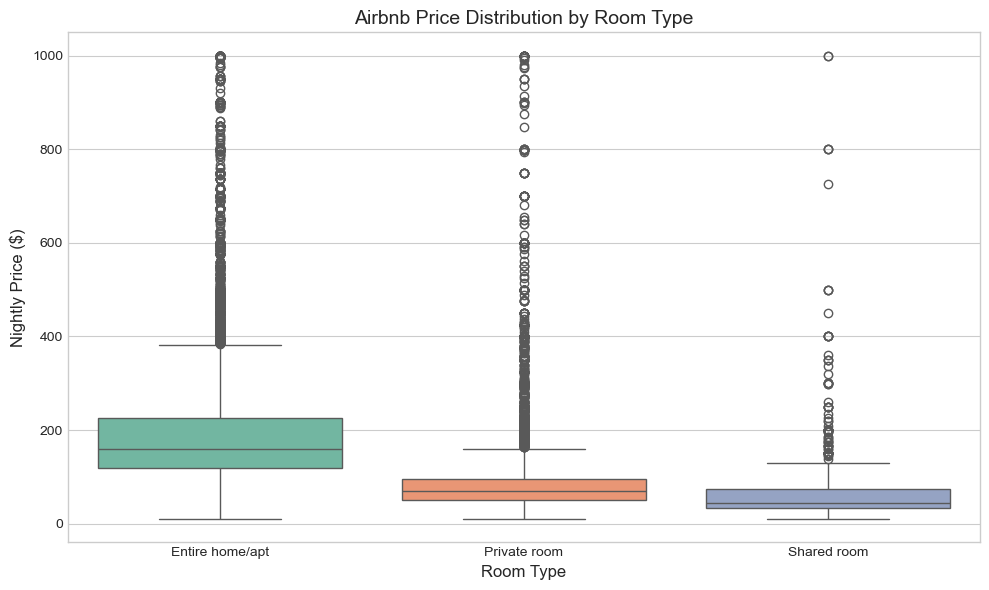

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
room_order = ['Entire home/apt', 'Private room', 'Shared room']
sns.boxplot(data=df_clean, x='room_type', y='price', order=room_order, palette='Set2', ax=ax)
ax.set_xlabel('Room Type', fontsize=12)
ax.set_ylabel('Nightly Price ($)', fontsize=12)
ax.set_title('Airbnb Price Distribution by Room Type', fontsize=14)
plt.tight_layout()
plt.show()

The boxplot clearly demonstrates the price hierarchy across room types. Entire homes/apartments have the highest median price and widest interquartile range, reflecting both their premium nature and diverse quality levels. Private rooms cluster at lower prices with less variation, while shared rooms represent the budget segment with the lowest median. This hierarchical pattern confirms that room type is a fundamental determinant of pricing that must be controlled when examining how transit accessibility affects prices—any analysis ignoring room type would confound property characteristics with location effects.

### Figure 3: Price vs. Distance to Nearest Subway Station (Scatter Plot)

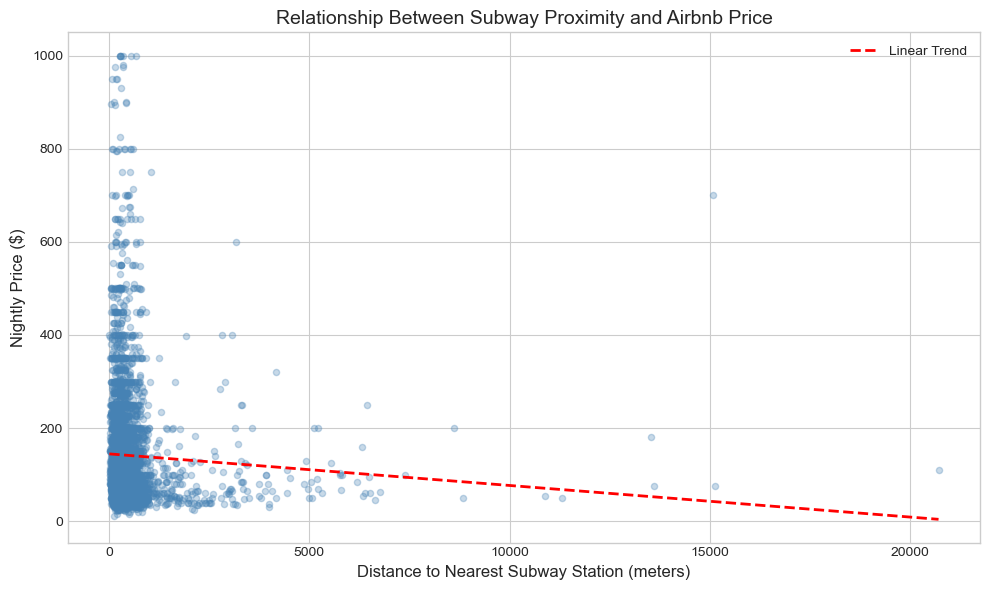

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
# Sample for clearer visualization
sample_df = df_clean.sample(n=5000, random_state=42)
ax.scatter(sample_df['distance_to_nearest_station_m'], sample_df['price'], 
           alpha=0.3, s=20, c='steelblue')
ax.set_xlabel('Distance to Nearest Subway Station (meters)', fontsize=12)
ax.set_ylabel('Nightly Price ($)', fontsize=12)
ax.set_title('Relationship Between Subway Proximity and Airbnb Price', fontsize=14)

# Add trend line
z = np.polyfit(sample_df['distance_to_nearest_station_m'], sample_df['price'], 1)
p = np.poly1d(z)
x_line = np.linspace(sample_df['distance_to_nearest_station_m'].min(), 
                     sample_df['distance_to_nearest_station_m'].max(), 100)
ax.plot(x_line, p(x_line), 'r--', linewidth=2, label='Linear Trend')
ax.legend()
plt.tight_layout()
plt.show()

This scatter plot directly examines the core research question: whether subway proximity affects Airbnb prices. The trend line suggests a slight negative relationship—prices tend to decrease as distance from subway stations increases, consistent with the transit accessibility hypothesis. However, substantial variation exists at all distances, indicating that subway proximity is one of many factors influencing prices. The relationship appears stronger at shorter distances (under 500 meters), where the convenience premium may be most relevant for guests. Properties very far from subway stations show consistently lower prices, supporting the mechanism that transit access contributes to rental value.

### Figure 4: Average Price and Transit Density by Borough (Grouped Bar Chart)

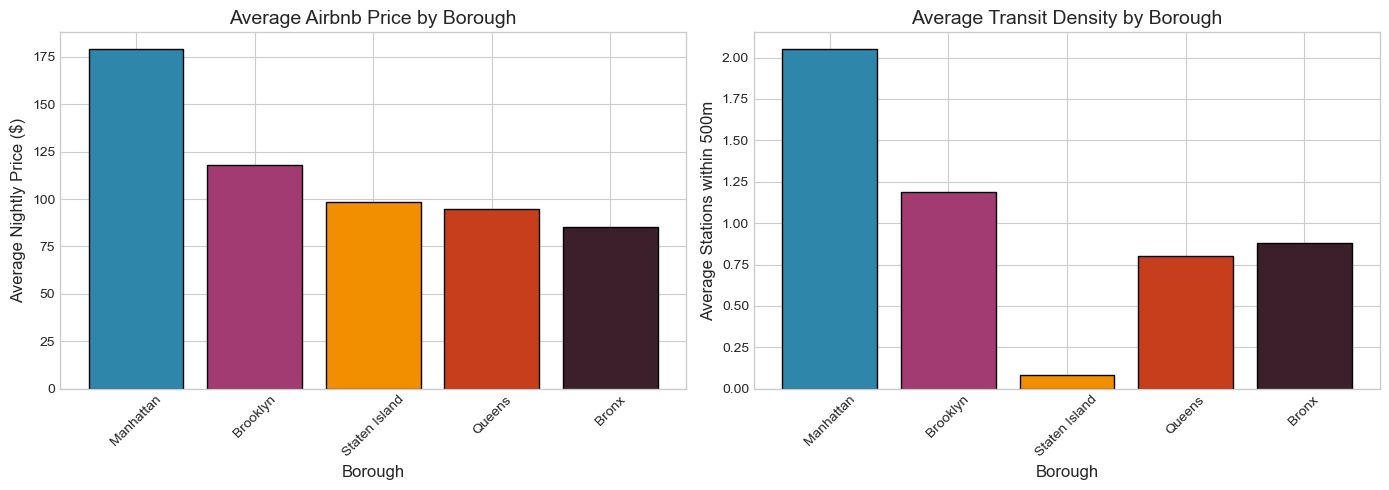


Borough Statistics:
                      price  stations_within_500m  \
neighbourhood_group                                 
Bronx                 85.36                  0.88   
Brooklyn             117.86                  1.19   
Manhattan            178.94                  2.05   
Queens                95.01                  0.80   
Staten Island         98.58                  0.08   

                     distance_to_nearest_station_m  
neighbourhood_group                                 
Bronx                                       621.12  
Brooklyn                                    385.16  
Manhattan                                   305.92  
Queens                                      979.57  
Staten Island                              4501.36  


In [11]:
# Group by borough and calculate means
borough_stats = df_clean.groupby('neighbourhood_group').agg({
    'price': 'mean',
    'stations_within_500m': 'mean',
    'distance_to_nearest_station_m': 'mean'
}).round(2)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Average price by borough
borough_order = borough_stats['price'].sort_values(ascending=False).index
colors = ['#2E86AB', '#A23B72', '#F18F01', '#C73E1D', '#3B1F2B']
axes[0].bar(borough_order, borough_stats.loc[borough_order, 'price'], color=colors, edgecolor='black')
axes[0].set_xlabel('Borough', fontsize=12)
axes[0].set_ylabel('Average Nightly Price ($)', fontsize=12)
axes[0].set_title('Average Airbnb Price by Borough', fontsize=14)
axes[0].tick_params(axis='x', rotation=45)

# Plot 2: Average stations within 500m by borough
axes[1].bar(borough_order, borough_stats.loc[borough_order, 'stations_within_500m'], color=colors, edgecolor='black')
axes[1].set_xlabel('Borough', fontsize=12)
axes[1].set_ylabel('Average Stations within 500m', fontsize=12)
axes[1].set_title('Average Transit Density by Borough', fontsize=14)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nBorough Statistics:")
print(borough_stats)

This side-by-side comparison reveals a striking pattern: boroughs with higher transit density also have higher average Airbnb prices. Manhattan leads in both dimensions, with the highest average prices and most subway stations within walking distance of listings. Brooklyn and Queens follow with moderate transit density and prices, while the Bronx and Staten Island have both lower transit access and lower average prices. This borough-level correlation provides supporting evidence for the transit accessibility mechanism—areas with better subway coverage command higher rental rates. However, this relationship likely reflects multiple correlated factors including tourism demand, neighborhood desirability, and overall economic activity that concentrate in transit-rich areas.

### Figure 5: Average Price by Distance to Subway (Binned Line Plot)

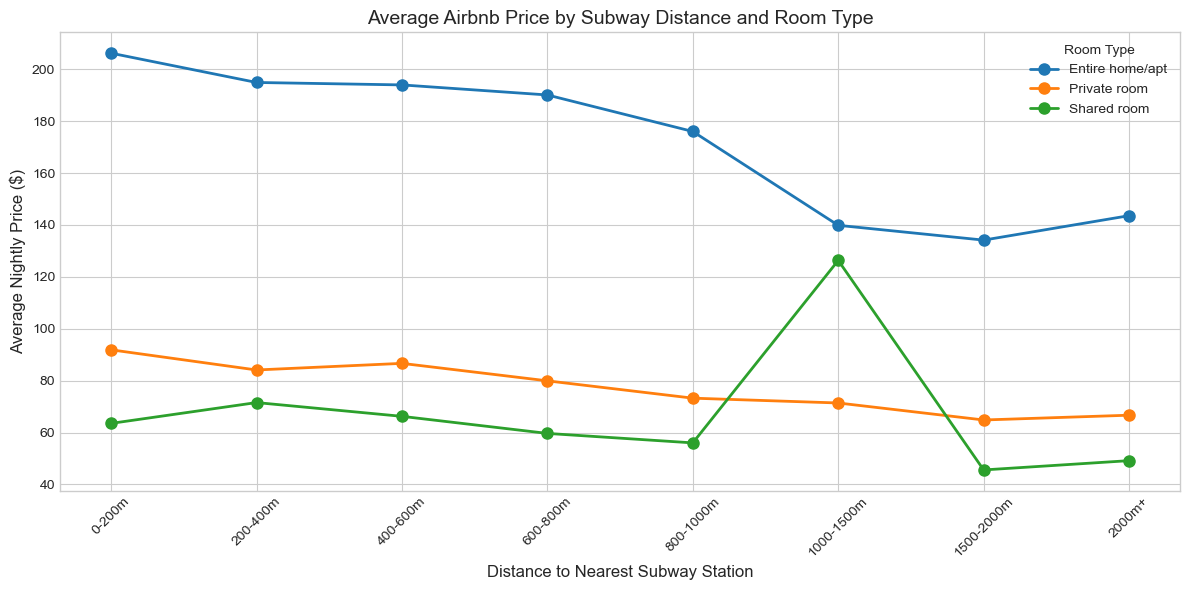

In [12]:
# Create distance bins
df_clean['distance_bin'] = pd.cut(df_clean['distance_to_nearest_station_m'], 
                                   bins=[0, 200, 400, 600, 800, 1000, 1500, 2000, float('inf')],
                                   labels=['0-200m', '200-400m', '400-600m', '600-800m', 
                                          '800-1000m', '1000-1500m', '1500-2000m', '2000m+'])

# Calculate average price by distance bin and room type
price_by_distance = df_clean.groupby(['distance_bin', 'room_type'])['price'].mean().unstack()

fig, ax = plt.subplots(figsize=(12, 6))
price_by_distance.plot(kind='line', marker='o', ax=ax, linewidth=2, markersize=8)
ax.set_xlabel('Distance to Nearest Subway Station', fontsize=12)
ax.set_ylabel('Average Nightly Price ($)', fontsize=12)
ax.set_title('Average Airbnb Price by Subway Distance and Room Type', fontsize=14)
ax.legend(title='Room Type', loc='upper right')
ax.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

This figure demonstrates how the price-distance relationship varies by room type, providing insight into heterogeneous effects of transit accessibility. For entire homes, prices decline notably as distance from subway stations increases, with the steepest drop occurring beyond 1000 meters. Private rooms show a similar but flatter pattern, suggesting transit accessibility matters less for budget-conscious travelers who may prioritize price over convenience. Shared rooms show minimal price variation across distance bins, indicating that guests choosing the most affordable option are least sensitive to subway access. These differential patterns support the mechanism hypothesis—transit accessibility commands a premium primarily for guests seeking convenience, who typically choose entire home rentals for their NYC visits.

## 5. Conclusion

This descriptive analysis provides preliminary evidence that subway accessibility is positively associated with Airbnb rental prices in New York City. Listings closer to subway stations tend to command higher nightly rates, and boroughs with denser transit networks show systematically higher average prices. The relationship appears strongest for entire home rentals, where guests presumably value convenience most highly, supporting the proposed mechanism that transit accessibility affects prices through guest utility from reduced transportation costs and increased mobility.

However, several limitations warrant caution in interpreting these patterns. The cross-sectional nature of this analysis cannot establish causality—higher prices near subway stations may reflect correlated neighborhood characteristics such as tourism demand, commercial activity, or overall desirability rather than transit access per se. Additionally, the 2019 Airbnb data predates the COVID-19 pandemic, which substantially disrupted both short-term rental markets and transit usage patterns. Future regression analysis can control for confounding variables and provide more rigorous estimates of the transit accessibility premium, while spatial analysis in subsequent projects can examine geographic clustering of high-value listings near transit hubs.

## References

Bowes, D. R., & Ihlanfeldt, K. R. (2001). Identifying the impacts of rail transit stations on residential property values. *Journal of Urban Economics*, 50(1), 1-25.

Dubé, J., Thériault, M., & Des Rosiers, F. (2013). Commuter rail accessibility and house values: The case of the Montreal South Shore, Canada, 1992–2009. *Transportation Research Part A: Policy and Practice*, 54, 49-66.

Gibbs, C., Guttentag, D., Gretzel, U., Morton, J., & Goodwill, A. (2018). Pricing in the sharing economy: A hedonic pricing model applied to Airbnb listings. *Journal of Travel & Tourism Marketing*, 35(1), 46-56.

Gunter, U., & Önder, I. (2018). Determinants of Airbnb demand in Vienna and their implications for the traditional accommodation industry. *Tourism Economics*, 24(3), 270-293.

Yao, Y., & Zhang, J. (2023). The effect of transportation infrastructure on sharing economy: Evidence from Airbnb. *Transportation Research Part A: Policy and Practice*, 169, 103595.